In [34]:
%cd
!chmod -R +w Emotionmodel
!rm -r Emotionmodel
!chmod -R +w Emotiondata
!rm -r Emotiondata
!git clone https://github.com/geeknoobie/Emotionmodel.git
!git clone https://github.com/geeknoobie/Emotiondata.git

/Users/debabratapanda
Cloning into 'Emotionmodel'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 48 (delta 1), reused 7 (delta 1), pack-reused 39
Receiving objects: 100% (48/48), 72.39 MiB | 21.71 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Cloning into 'Emotiondata'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 27 (delta 9), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (27/27), 23.29 MiB | 9.49 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [18]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
import nltk
nltk.download('punkt')
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/debabratapanda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 1. Data Loading

In [19]:
# loading the data
df = pd.read_csv('/Users/debabratapanda/Emotiondata/Book1.csv')
# splitting data into text and labels
texts = df['text'].tolist()
labels = df['emotion'].tolist()

## 2. EDA to understand the characteristics of the data.

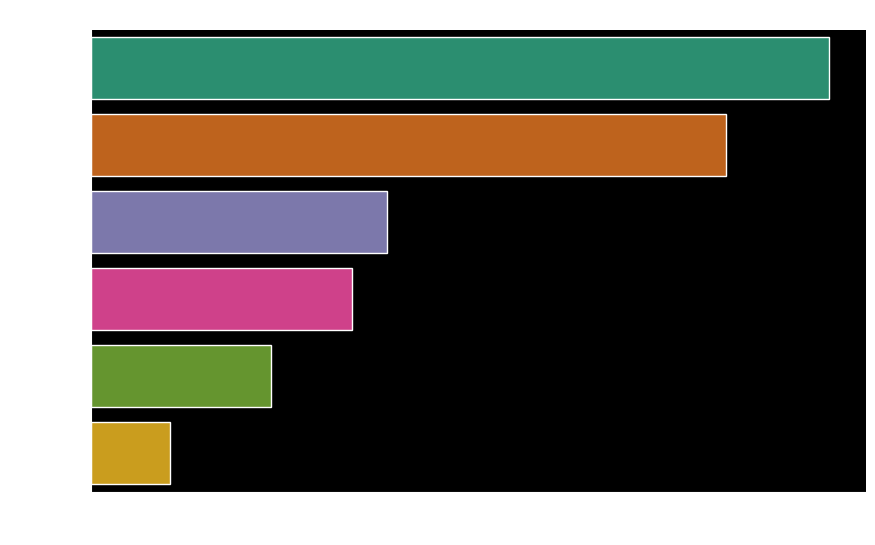

In [20]:
# Calculate counts for each emotion category
emotion_counts = df['emotion'].value_counts()

# Sort the counts in descending order
sorted_emotion_counts = emotion_counts.sort_values(ascending=False)

# Plot the sorted counts
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_emotion_counts.values, y=sorted_emotion_counts.index, palette='Dark2')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Emotion')
plt.title('Count of Emotions')
plt.gcf().set_facecolor('none')
plt.gca().grid(alpha=0)
plt.show()

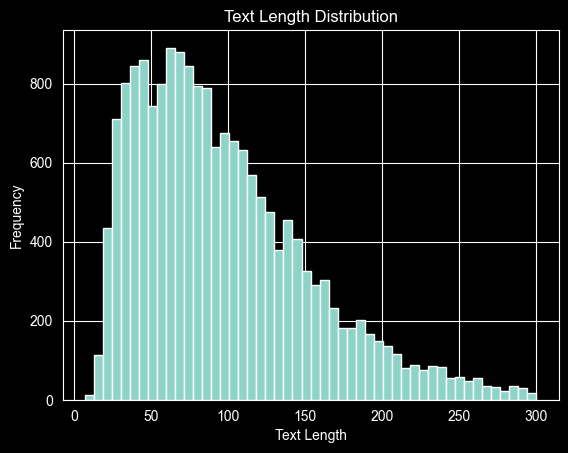

In [21]:
# Calculate text lengths
text_lengths = df['text'].apply(len)
# Plot text length distribution
plt.hist(text_lengths, bins=50)
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.title('Text Length Distribution')
plt.show()

## 3.Text Pre-Processing:

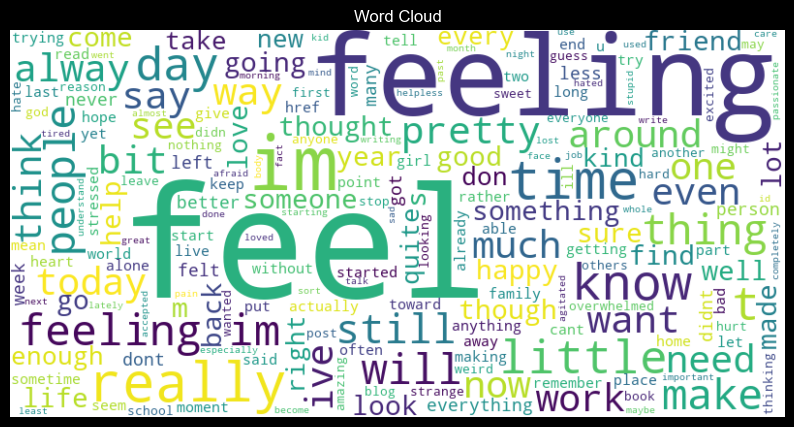

In [22]:
# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Convert sequences back to words
word_index = tokenizer.word_index
tokens = [word for seq in sequences for word, index in word_index.items() if index in seq]

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

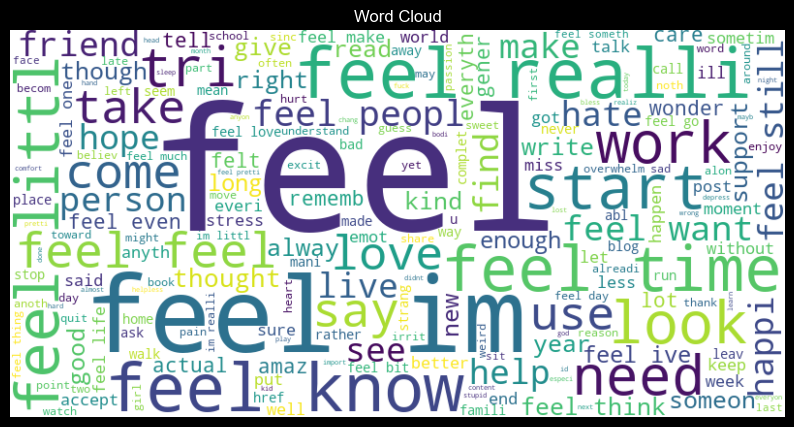

In [23]:
# Lower casing
tokens = [word.lower() for word in tokens]

# Remove punctuation
tokens = [word for word in tokens if word not in string.punctuation]

# Remove stopwords
stop_words = set(stopwords.words('english'))
tokens = [word for word in tokens if word not in stop_words]

# Stemming using NLTK
stemmer = PorterStemmer()
tokens = [stemmer.stem(word) for word in tokens]
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [24]:
# Pad sequences to ensure uniform length
maxlen = max(len(seq) for seq in sequences)
sequences_padded = pad_sequences(sequences, maxlen=maxlen)

In [25]:
# Convert labels to one-hot encoding
label_to_index = {label: i for i, label in enumerate(set(labels))}
index_to_label = {i: label for label, i in label_to_index.items()}
labels_encoded = np.array([label_to_index[label] for label in labels])

In [26]:
index_to_label

{0: 'joy', 1: 'sadness', 2: 'fear', 3: 'surprise', 4: 'anger', 5: 'love'}

## 4. Train-validation Split:

In [27]:
# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(sequences_padded, labels_encoded, test_size=0.2, random_state=42)

## 5. Model Building

In [28]:
# Define the model
embedding_dims = 50
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dims, input_length=maxlen))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(label_to_index), activation='softmax'))

In [29]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val))

Epoch 1/5
450/450 [==============================] - 20s 37ms/step - loss: 1.3228 - accuracy: 0.4953 - val_loss: 0.7992 - val_accuracy: 0.7078
Epoch 2/5
450/450 [==============================] - 16s 35ms/step - loss: 0.4934 - accuracy: 0.8340 - val_loss: 0.3500 - val_accuracy: 0.8783
Epoch 3/5
450/450 [==============================] - 16s 35ms/step - loss: 0.1977 - accuracy: 0.9347 - val_loss: 0.2687 - val_accuracy: 0.9056
Epoch 4/5
450/450 [==============================] - 16s 36ms/step - loss: 0.1345 - accuracy: 0.9572 - val_loss: 0.2684 - val_accuracy: 0.9078
Epoch 5/5
450/450 [==============================] - 16s 35ms/step - loss: 0.0970 - accuracy: 0.9701 - val_loss: 0.2591 - val_accuracy: 0.9125


## 6. Model Evaluation

In [32]:
# loading the data for test account 
df1 = pd.read_csv('/Users/debabratapanda/Emotiondata/Book2.csv')
# splitting data into text and labels
texts = df['text'].tolist()
labels = df['emotion'].tolist()
# Tokenize text data
tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(texts)
sequences1 = tokenizer1.texts_to_sequences(texts)
# Pad sequences to ensure uniform length
maxlen1 = max(len(seq) for seq in sequences1)
sequences_padded1 = pad_sequences(sequences1, maxlen=maxlen1)
# Convert labels to one-hot encoding
label_to_index1 = {label: i for i, label in enumerate(set(labels))}
index_to_label1 = {i: label for label, i in label_to_index1.items()}
labels_encoded1 = np.array([label_to_index1[label] for label in labels])
# Create testing set 
X_train, X_test, y_train, y_test = train_test_split(sequences_padded, labels_encoded, test_size=0.99, random_state=42)

In [33]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print('Test accuracy:', accuracy)

557/557 [==============================] - 6s 10ms/step - loss: 0.0947 - accuracy: 0.9690
Test accuracy: 0.9689674377441406


## 7.Testing the model on random texts

In [39]:
# Example usage
def predict_emotion(text):
    # Preprocess text
    sequence = tokenizer.texts_to_sequences([text])
    sequence_padded = pad_sequences(sequence, maxlen=maxlen)

    # Predict emotion
    prediction = model.predict(sequence_padded)[0]
    predicted_index = np.argmax(prediction)
    predicted_label = index_to_label[predicted_index]
    return predicted_label

In [40]:
while True:
    # Input text
    input_text = input("Enter text (type 'exit' to quit): ")

    # Check if user wants to exit
    if input_text.lower() == 'exit':
        print("Exiting...")
        break

    # Predict emotion
    predicted_emotion = predict_emotion(input_text)
    print(f"Statement: {input_text},\n Predicted emotion: {predicted_emotion}")

1/1 [==============================] - 1s 596ms/step
Statement: i was sad,
 Predicted emotion: sadness
1/1 [==============================] - 0s 23ms/step
Statement: ,
 Predicted emotion: anger
Exiting...


## 8.Airline reviews

In [35]:
ar_df = pd.read_csv('/Users/debabratapanda/Emotiondata/Airline_review.csv')
ar_df[:5]

,Review
0,Moroni to Moheli. Turned out to be a pretty de...
1,Moroni to Anjouan. It is a very small airline....
2,Anjouan to Dzaoudzi. A very small airline and ...
3,Please do a favor yourself and do not fly with...
4,Do not book a flight with this airline! My fri...


In [37]:
ar_df['predicted_emotion'] = ''
ar_df

,Review,predicted_emotion
0,Moroni to Moheli. Turned out to be a pretty de...,
1,Moroni to Anjouan. It is a very small airline....,
2,Anjouan to Dzaoudzi. A very small airline and ...,
3,Please do a favor yourself and do not fly with...,
4,Do not book a flight with this airline! My fri...,
...,...,...
23166,Bangkok to Tokyo. I’ve flown many low cost air...,
23167,Avoid at all costs. I booked flights to go fro...,
23168,Flight was leaving at 23.15 and after an hour ...,
23169,Zipair is JAL’s budget airline. They don’t hav...,


In [41]:
# Iterate over each review
for i, r in enumerate(ar_df['Review']):
    predicted_emotion = predict_emotion(r)
    ar_df.at[i, 'predicted_emotion'] = predicted_emotion

1/1 [==============================] - 0s 24ms/step


In [42]:
ar_df

,Review,predicted_emotion
0,Moroni to Moheli. Turned out to be a pretty de...,joy
1,Moroni to Anjouan. It is a very small airline....,joy
2,Anjouan to Dzaoudzi. A very small airline and ...,sadness
3,Please do a favor yourself and do not fly with...,surprise
4,Do not book a flight with this airline! My fri...,sadness
...,...,...
23166,Bangkok to Tokyo. I’ve flown many low cost air...,sadness
23167,Avoid at all costs. I booked flights to go fro...,anger
23168,Flight was leaving at 23.15 and after an hour ...,joy
23169,Zipair is JAL’s budget airline. They don’t hav...,joy


# Conclusion: